_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [28]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.signal import butter, filtfilt
from scipy import signal

jupyter_black.load()

## Context
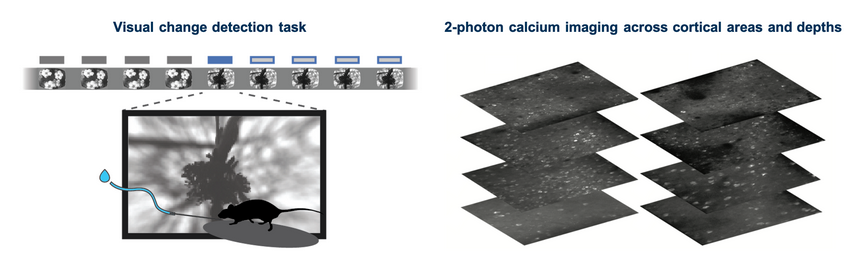

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

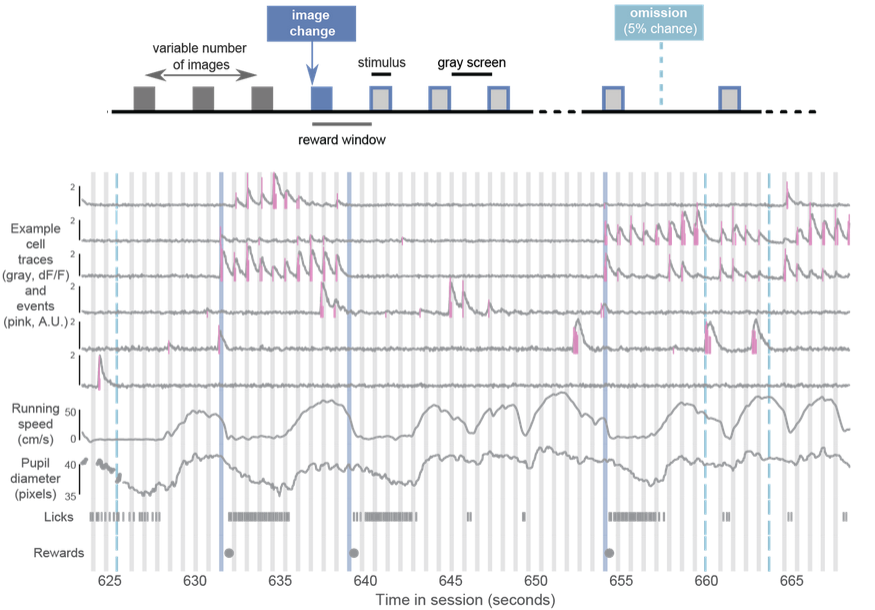

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [3]:
# adjust the path as necessary
file_path = "/Users/sascha/Library/Mobile Documents/com~apple~CloudDocs/Uni_Tübingen/Semester2/NeuralDataScience/Assignments/FinalProject/data/project-01"


# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["frequency", "direction", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(path=file_path)

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure in the preferred orientation/direction/frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# 1 Preprocessing

## 1.1 Data Loading and Filtering

In [20]:
# extract data and create DataFrame
data = np.load(file_path + "/dff_data_dsi.npz", allow_pickle=True)

t = data["t"]  # time vector
dff = data["dff"]  # calcium traces
roi_masks = data["roi_masks"]
max_proj = data["max_projection"]
running_speed = data["running_speed"]

# load DataFrame
stim_table = pd.DataFrame(
    data["stim_table"],
    columns=["frequency", "direction", "blank_sweep", "start", "end"],
)

# transpose so rows are timepoints and columns are neurons
df_dff = pd.DataFrame(dff.T, columns=[f"neuron_{i+1}" for i in range(dff.shape[0])])

# add time vector as a column
df_dff.insert(0, "time", t)

# transform the df such that neuron is one column
df_dff = df_dff.melt(id_vars=["time"], var_name="neuron", value_name="dff")

df_dff

,time,neuron,dff
0,9.67741,neuron_1,0.080074
1,9.71067,neuron_1,0.073333
2,9.74392,neuron_1,0.106239
3,9.77718,neuron_1,0.046158
4,9.81043,neuron_1,0.085196
...,...,...,...
12239921,3849.48696,neuron_106,0.209696
12239922,3849.52022,neuron_106,0.082179
12239923,3849.55347,neuron_106,0.092020
12239924,3849.58673,neuron_106,0.197644


In [49]:
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)
stim_table

,frequency,direction,blank_sweep,start,end
0,1.0,225.0,0.0,747,807
1,2.0,180.0,0.0,837,897
2,4.0,90.0,0.0,927,987
3,1.0,270.0,0.0,1018,1077
4,4.0,135.0,0.0,1108,1168
...,...,...,...,...,...
623,4.0,315.0,0.0,114794,114854
624,2.0,45.0,0.0,114884,114944
625,4.0,180.0,0.0,114975,115034
626,4.0,270.0,0.0,115065,115125


We start by looking at what the the raw data looks like for one example neuron:

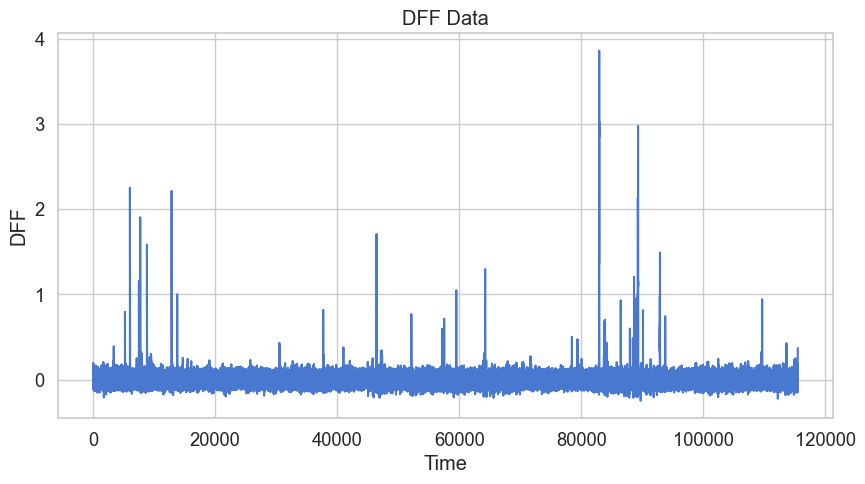

In [ ]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


def plot_dff(data, neuron=0):
    """
    Plot the dff data for a given neuron and stimulus epoch.

    Parameters:
    - df: The DataFrame containing the dff data.
    - neuron: The index of the neuron to plot.
    - stim_epoch: The index of the stimulus epoch to plot.
    """
    dff = data["dff"]

    plt.figure(figsize=(10, 5))
    plt.plot(
        dff[neuron],
        label=f"Neuron {neuron}",
    )
    plt.title("DFF Data")
    plt.xlabel("Time")
    plt.ylabel("DFF")
    plt.show()


# Example plot for one neuron
plot_dff(data)

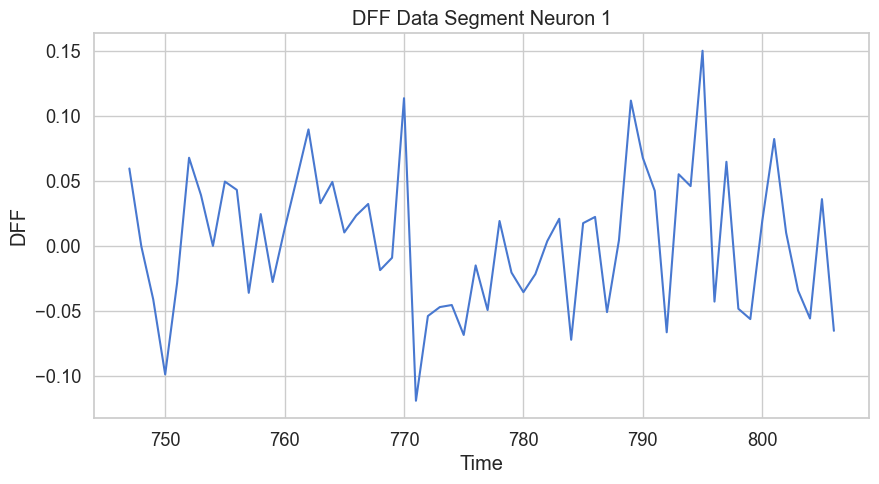

In [17]:
# look at specific trial / segment of the data for the example neuron
plt.figure(figsize=(10, 5))

# extract stimulus epoch for the example neuron
stim_epoch = stim_table.iloc[0]  # first trial
start, end = int(stim_epoch["start"]), int(stim_epoch["end"])

plt.plot(
    df_dff["neuron_1"][start:end],
    label="Neuron 1",
)
plt.title("DFF Data Segment Neuron 1")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.show()

In [ ]:
def butterworth_filter(df, cutoff=0.1, fs=1.0, order=5):
    """
    Apply a Butterworth filter to the data.

    Parameters:
    - df: DataFrame containing the dff data.
    - cutoff: The cutoff frequency of the filter.
    - fs: The sampling frequency of the data.
    - order: The order of the filter.

    Returns:
    - The filtered data.
    """
    # compute Nyquist frequency
    nyquist = 0.5 * fs
    # normalize cutoff frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, df["dff"], axis=0)
    return filtered_data

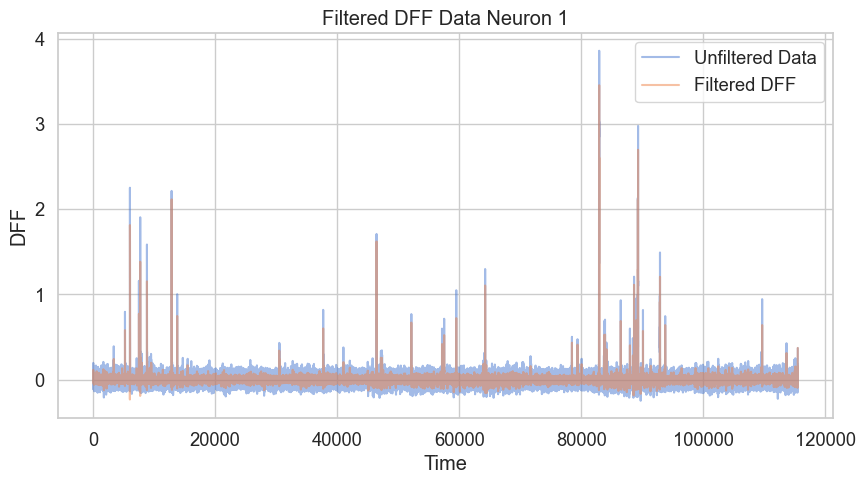

In [23]:
# Apply the filter to the dff data for one example neuron
filtered_dff = butterworth_filter(
    df_dff[df_dff["neuron"] == "neuron_1"], cutoff=0.1, fs=1.0, order=5
)
# Plot the filtered dff data
plt.figure(figsize=(10, 5))
plt.plot(
    df_dff[df_dff["neuron"] == "neuron_1"]["dff"],
    label=f"Unfiltered Data",
    alpha=0.5,
)
plt.plot(filtered_dff, label="Filtered DFF", alpha=0.5)
plt.title("Filtered DFF Data Neuron 1")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

The filtering process has smoothed the signal, reducing noise while preserving the essential features of the neural activity. This will help in further analyses such as identifying peaks, calculating statistics, or visualizing the data more clearly.
We can now therefore apply the filter to all neurons:

In [27]:
# apply filter to all neurons
df_dff["filtered_dff"] = butterworth_filter(df_dff, cutoff=0.1, fs=1.0, order=5)
df_dff.head()

,time,neuron,dff,filtered_dff
0,9.67741,neuron_1,0.080074,0.080087
1,9.71067,neuron_1,0.073333,0.080391
2,9.74392,neuron_1,0.106239,0.082762
3,9.77718,neuron_1,0.046158,0.088371
4,9.81043,neuron_1,0.085196,0.096789


# 2 Spike Inference

## 2.1 Spike Detection

We can now continue with the analysis using the filtered data. First, we detect the spikes in the entire dataset for each neuron.

In [30]:
def detect_spikes(
    df: pd.DataFrame, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    df: pd.DataFrame
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # compute the robust s.d. and calculate the threshold

    # extract the filtered dff data
    x = df["filtered_dff"].values

    sigma = np.median(np.abs(x - np.mean(x))) / 0.6745
    threshold = N * sigma

    # Lockout in samples
    lockout_samples = int((lockout / 1000) * fs)

    # find all spikes

    # Candidate positive peaks
    pos_peaks, _ = signal.find_peaks(x, distance=lockout_samples)
    pos_peaks = pos_peaks[x[pos_peaks] >= threshold]

    # negative peaks are not used because they coocur too close to the positive peaks

    peaks = pos_peaks

    spike_times = peaks * (1000 / fs)  # convert to ms

    return peaks, spike_times, threshold

/Users/sascha/anaconda3/envs/NeuralDataScience/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


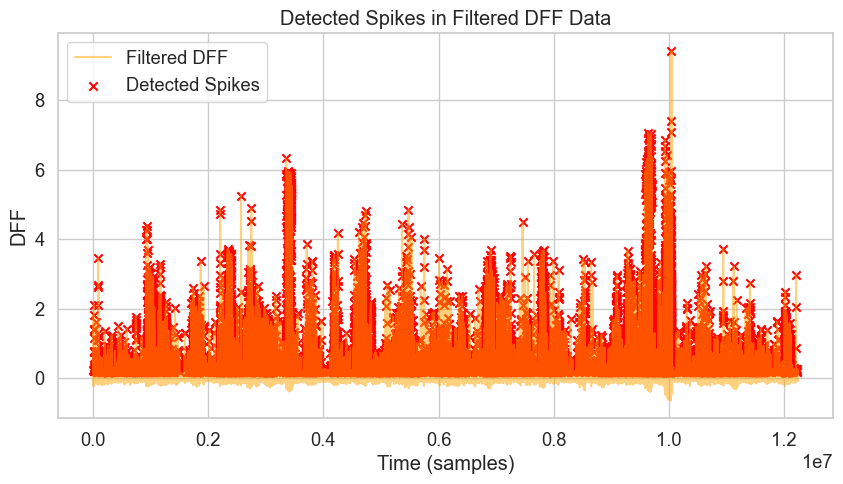

Detected 20812 spikes with threshold 0.18.


In [44]:
# detect spikes in the filtered dff
spikes, spike_times, threshold = detect_spikes(df_dff, fs=1000, N=5, lockout=1.0)

# plot the detected spikes
plt.figure(figsize=(10, 5))
plt.plot(df_dff["filtered_dff"], label="Filtered DFF", color="orange", alpha=0.5)
plt.scatter(
    spikes,
    df_dff["filtered_dff"][spikes],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

print(f"Detected {len(spikes)} spikes with threshold {threshold:.2f}.")

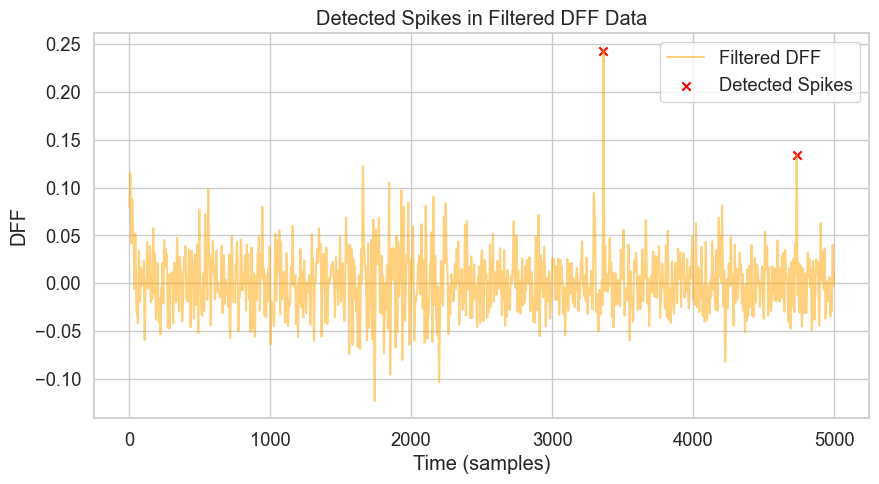

In [ ]:
# Filter the data for a specific neuron and a short segment
neuron_data = df_dff[df_dff["neuron"] == "neuron_1"].iloc[0:5000]

# Detect spikes in the filtered dff data for the specific neuron
spikes, spike_times, threshold = detect_spikes(neuron_data, fs=5000, N=5, lockout=1.0)

# Plot the filtered DFF data and detected spikes
plt.figure(figsize=(10, 5))
plt.plot(
    neuron_data["filtered_dff"].values,
    label="Filtered DFF",
    color="orange",
    alpha=0.5,
)
# Add spikes
plt.scatter(
    spikes,
    neuron_data["filtered_dff"].values[spikes],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

In [47]:
# detect spikes and add them to the DataFrame
df_dff["spikes"] = 0
df_dff.loc[spikes, "spikes"] = 1
df_dff["spike_time"] = 0
df_dff.loc[spike_times, ["spike_time"]] = spike_times
df_dff.head()

,time,neuron,dff,filtered_dff,spikes,spike_time
0,9.67741,neuron_1,0.080074,0.080087,0,0
1,9.71067,neuron_1,0.073333,0.080391,0,0
2,9.74392,neuron_1,0.106239,0.082762,0,0
3,9.77718,neuron_1,0.046158,0.088371,0,0
4,9.81043,neuron_1,0.085196,0.096789,0,0


## 2.2 Segment data by stimulus presentation and epochs


Since we want to analyze each neuron´s preference for direction and frequency we need to look at the signal directly after a stimulus presentation. Therefore, we split the data into segements for each trial.

In [ ]:
df_dff["trial"] = 0
df_dff["frequency"] = 0
df_dff["direction"] = 0

for i, row in stim_table.iterrows():
    # add a column to df_dff for trials as indicated by the stim_table
    start, end = row["start"], row["end"]
    df_dff.loc[(df_dff["time"] >= start) & (df_dff["time"] <= end), "trial"] = i + 1
    # add a column for the stimulus frequency
    start, end = row["start"], row["end"]
    df_dff.loc[(df_dff["time"] >= start) & (df_dff["time"] <= end), "frequency"] = row[
        "frequency"
    ]
    # add a column for the stimulus direction
    start, end = row["start"], row["end"]
    df_dff.loc[(df_dff["time"] >= start) & (df_dff["time"] <= end), "direction"] = row[
        "direction"
    ]

df_dff.head()

,time,neuron,dff,filtered_dff,spikes,spike_time,time_match,trial,frequency,direction
0,9.67741,neuron_1,0.080074,0.080087,0,0,False,0,0.0,0.0
1,9.71067,neuron_1,0.073333,0.080391,0,0,False,0,0.0,0.0
2,9.74392,neuron_1,0.106239,0.082762,0,0,False,0,0.0,0.0
3,9.77718,neuron_1,0.046158,0.088371,0,0,False,0,0.0,0.0
4,9.81043,neuron_1,0.085196,0.096789,0,0,False,0,0.0,0.0


In [70]:
# reduce the DataFrame to only the relevant columns
df_dff_reduced = df_dff[["time", "neuron", "spikes", "trial", "frequency", "direction"]]
# remove rows with no spikes
df_dff_reduced = df_dff_reduced[df_dff_reduced["spikes"] == 1]
# remove rows without trial information or direction
df_dff_reduced = df_dff_reduced[
    df_dff_reduced["trial"].notna() & df_dff_reduced["direction"].notna()
]
# make neuron a numeric column
df_dff_reduced["neuron"] = df_dff_reduced["neuron"].str.extract("(\d+)").astype(int)
df_dff_reduced

,time,neuron,spikes,trial,frequency,direction
3364,121.54321,1,1,0,0.0,0.0
5205,182.76372,1,1,0,0.0,0.0
6016,209.73270,1,1,0,0.0,0.0
6029,210.16500,1,1,0,0.0,0.0
6041,210.56405,1,1,0,0.0,0.0
...,...,...,...,...,...,...
12209590,2840.81240,106,1,24,4.0,45.0
12209615,2841.64378,106,1,24,4.0,45.0
12209629,2842.10936,106,1,24,4.0,45.0
12225974,3385.66998,106,1,30,15.0,270.0


Plot raster plots for each neuron to visualize the spike times across trials. This will help us understand the firing patterns of each neuron in response to the stimulus.

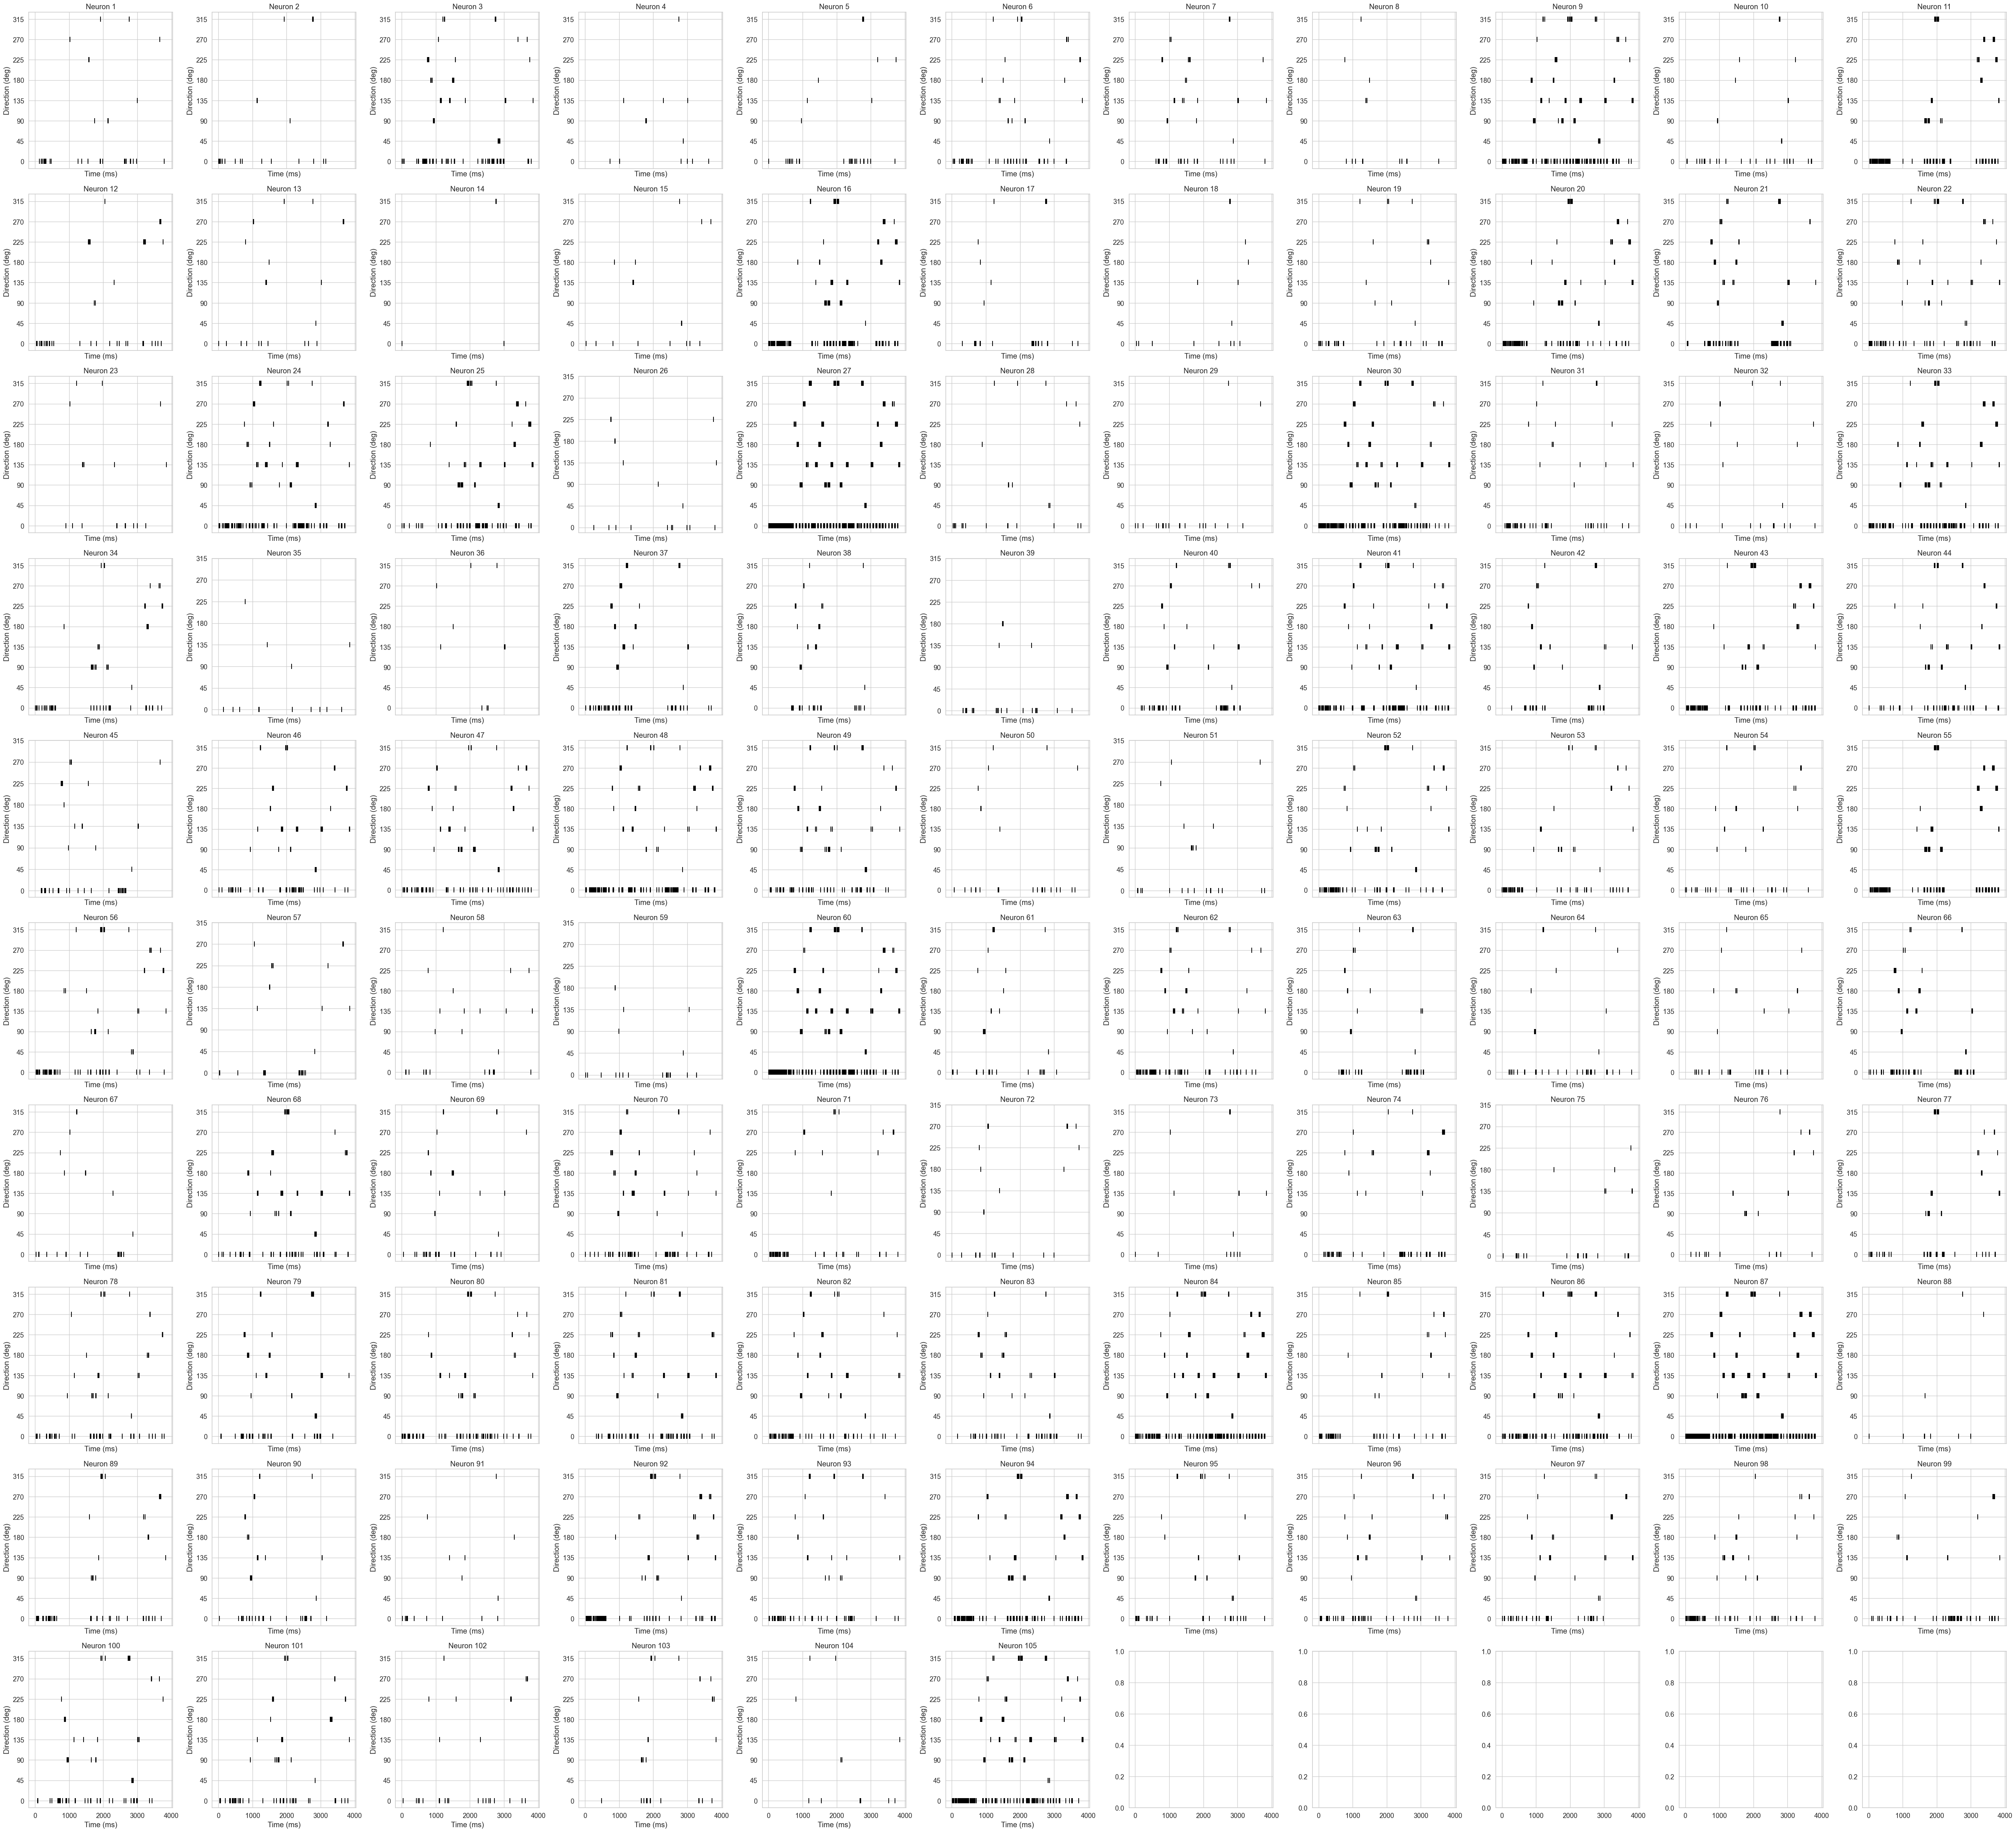

In [78]:
stimDur = 4000  # duration of the stimulus in ms
deltaDir = 45  # direction step in degrees


def plotRaster(df: pd.DataFrame, neurons: list):
    """Plot spike rasters for multiple neurons sorted by condition.

    Parameters
    ----------
    df: pd.DataFrame
        Pandas DataFrame with columns
            time | neuron | spikes | trial | frequency | direction

    neurons: list
        List of neuron IDs to plot.

    Note
    ----
    This function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    # create subplots based on the number of neurons
    n_neurons = len(neurons)
    n_cols = int(np.ceil(np.sqrt(n_neurons)))
    n_rows = int(np.ceil(n_neurons / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True
    )

    # flatten axes array and trim excess if needed
    axes = axes.flatten()

    # ensure axes is iterable even for a single neuron
    if n_neurons == 1:
        axes = [axes]

    for ax, neuron in zip(axes, neurons):
        # filter data for the current neuron
        x = df.loc[df["neuron"] == neuron, "time"]
        y = df.loc[df["neuron"] == neuron, "direction"]

        # create a scatter plot on the provided axis
        ax.scatter(x, y, marker="|", color="black", s=100)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Direction (deg)")
        ax.set_title(f"Neuron {neuron}")
        ax.set_yticks(np.arange(0, 360, deltaDir))
        ax.set_xticks(np.arange(0, stimDur + 1, 1000))

    plt.tight_layout()
    plt.show()


plotRaster(df_dff_reduced, neurons=list(range(1, 106)))

In [72]:
# vonMises tuning curve estimation
def vonMises(
    theta: np.ndarray, alpha: float, kappa: float, ny: float, phi: float
) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    theta, phi = np.deg2rad(theta), np.deg2rad(phi)

    return np.exp(
        alpha + kappa * (np.cos(2 * (theta - phi)) - 1) + ny * (np.cos(theta - phi) - 1)
    )

In [73]:
def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, neuron, show: bool = True
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    (alpha, kappa, ny, phi), _ = opt.curve_fit(vonMises, dirs, counts, maxfev=100000)

    if show:

        theta = np.linspace(0, 360, 1000)
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(f"Von Mises Tuning Curve for Neuron {neuron}", fontsize=16)
        ax.plot(dirs, counts.mean(axis=1), "o", label="Data")
        ax.plot(theta, vonMises(theta, alpha, kappa, ny, phi), label="Fitted Curve")
        ax.set_xlabel("Direction (degrees)")
        ax.set_ylabel("Spike Count")
        ax.set_title(
            f"Alpha: {alpha:.2f}, Kappa: {kappa:.2f}, Ny: {ny:.2f}, Phi: {phi:.2f}"
        )
        ax.set_xlim(0, 360)
        ax.set_ylim(0, counts.max() * 1.2)
        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xticklabels(np.arange(0, 361, 45))
        ax.set_yticks(np.arange(0, counts.max() * 1.2, 5))
        ax.set_yticklabels(np.arange(0, counts.max() * 1.2, 5))
        ax.grid()
        ax.legend()
        plt.show()
    return np.array([alpha, kappa, ny, phi])

In [74]:
def get_data(df, neuron):
    """Get the spike counts and directions for a specific neuron.
    Parameters
    ----------
    df: pd.DataFrame
        DataFrame containing the spike data with columns:
            time | neuron | spikes | trial | frequency | direction
    neuron: int
        The neuron ID for which to retrieve the data.
    Returns
    -------
    dirs_sorted: np.ndarray
        Sorted array of unique directions for the specified neuron.
    counts_sorted: np.ndarray
        Sorted array of spike counts corresponding to the unique directions.
    """

    # Filter for the given neuron
    spk_by_dir = (
        df[df["neuron"] == neuron]
        .groupby(["direction", "trial"])
        .size()  # Count the number of spikes per direction and trial
        .reset_index(name="spike_count")
    )

    dirs = spk_by_dir["direction"].values
    counts = spk_by_dir["spike_count"].values

    # Ensure zero entries for missing directions
    for direction in np.unique(df["direction"]):
        if direction not in dirs:
            dirs = np.append(dirs, direction)
            counts = np.append(counts, 0)

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

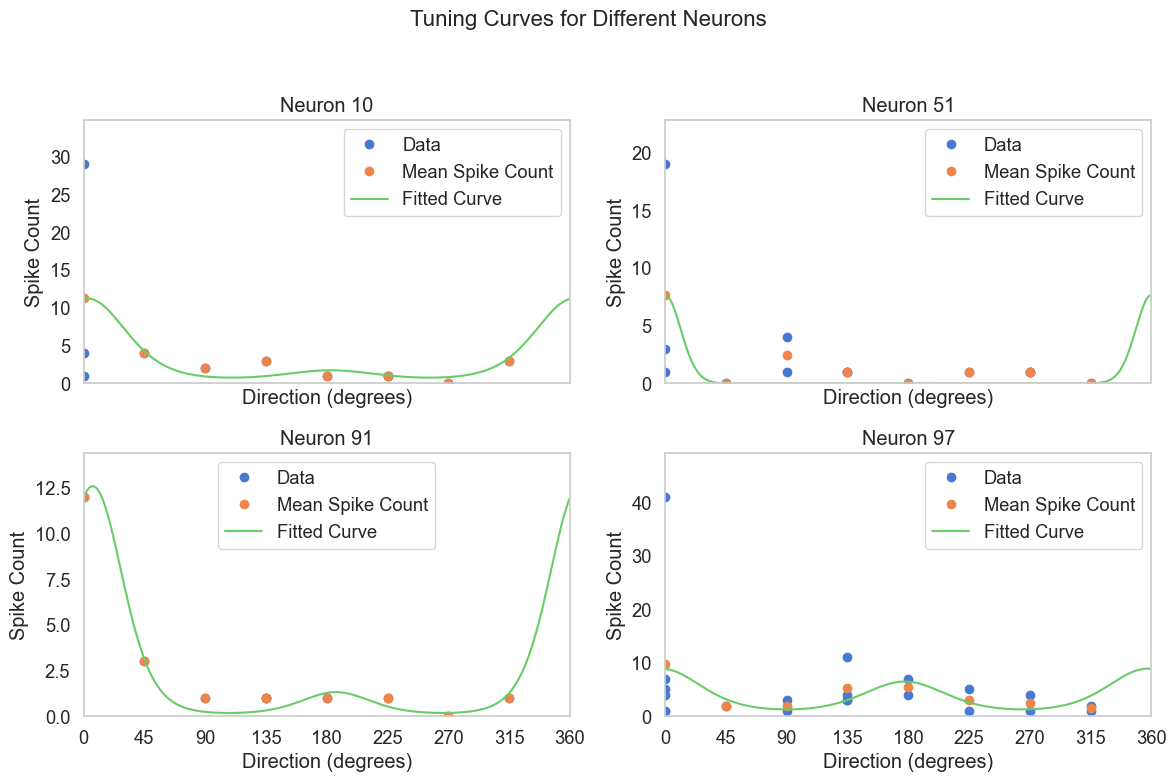

In [75]:
# List of neurons to plot
neurons = [10, 51, 91, 97]  # Example neuron indices, adjust as needed

fig, axes = plt.subplots(len(neurons) // 2, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Tuning Curves for Different Neurons", fontsize=16)
axes = axes.flatten()

for i, neuron in enumerate(neurons):
    ax = axes[i]
    dirs, counts = get_data(df_dff_reduced, neuron)

    unique_dirs = np.sort(np.unique(dirs))
    df = pd.DataFrame({"Counts": counts, "Direction": dirs}).groupby("Direction").mean()

    α0 = np.log(np.max(df.values.flatten()) + 1e-3)
    ϕ0 = unique_dirs[np.argmax(df.values.flatten())]
    p0 = [α0, 1.0, 1.0, ϕ0]

    try:
        p, _ = opt.curve_fit(
            vonMises, df.index.values, df.values.flatten(), p0=p0, maxfev=10000
        )
    except RuntimeError:
        p = p0  # fallback to initial guess if fitting fails

    ax.plot(dirs, counts, "o", label="Data")
    ax.plot(df.index.values, df.values.flatten(), "o", label="Mean Spike Count")
    theta = np.linspace(0, 360, 1000)
    ax.plot(theta, vonMises(theta, *p), label="Fitted Curve")
    ax.set_title(f"Neuron {neuron}")
    ax.set_xlabel("Direction (degrees)")
    ax.set_ylabel("Spike Count")
    ax.set_xlim(0, 360)
    ax.set_ylim(0, counts.max() * 1.2)
    ax.set_xticks(np.arange(0, 361, 45))
    ax.grid()
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()